<a href="https://colab.research.google.com/github/ReidelVichot/PUS2022_Heat-TreesPHL/blob/main/MidTermCleaning_12-2-22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
#Importing the dataframes from the websites
heat_original = gpd.GeoDataFrame.from_file("https://opendata.arcgis.com/api/v3/datasets/ee1f9ce6aa6f41f08fcdfa5101f203d7_0/downloads/data?format=shp&spatialRefId=4326&where=1%3D1")
trees_original = gpd.GeoDataFrame.from_file("https://opendata.arcgis.com/api/v3/datasets/30ef36e9e880468fa74e2d5b18da4cfb_0/downloads/data?format=shp&spatialRefId=4326")



In [31]:
#Checking the shapes of the geodataframes before cleaning them.
print(trees_original.shape, heat_original.shape)

(152453, 7) (384, 11)


In [32]:
trees_original[["TREE_DBH"]].dropna(axis=0)

,TREE_DBH
0,36.0
2,8.0
3,12.0
4,17.0
5,10.0
...,...
152448,5.0
152449,3.0
152450,7.0
152451,2.0


In [33]:
#Eliminating creating another dataframe with the columns of interest and without NAN values.
heat = heat_original[["GEOID10", "HVI_SCORE", "geometry"]].dropna().reset_index()
heat.drop(columns=["index"], inplace=True)

trees = trees_original[["geometry"]].dropna().reset_index()
trees_dbh = trees_original[["geometry", "TREE_DBH"]].dropna().reset_index()
#trees_dbh = trees_original[["TREE_DBH"]].dropna().reset_index()

trees.drop(columns=["index"], inplace=True)
trees_dbh.drop(columns=["index"], inplace=True)

#Printing the shapes of the clean dataframes
print(trees.shape, trees_dbh.shape, heat.shape)

(152453, 1) (152241, 2) (374, 3)


the heat data had 10 rows with NAN that were eliminated

In [34]:
trees_dbh.describe()
#there is a max value of 2028 that looks like an outlier.

,TREE_DBH
count,152241.000000
mean,12.956631
std,14.024025
min,0.000000
25%,4.000000
50%,10.000000
75%,20.000000
max,2028.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc85b336880>]],
      dtype=object)

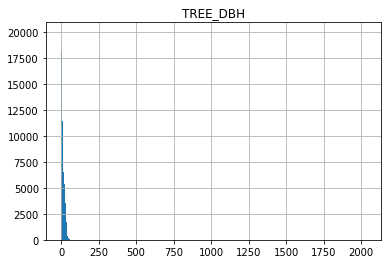

In [35]:
trees_dbh.hist(bins=1000)
#Yes, it is an outlier, probably an data error. I will substitute for 0

In [36]:
#trees_dbh = trees_dbh.loc[trees_dbh["TREE_DBH"]!=trees_dbh["TREE_DBH"].max()]
#trees_dbh = trees_dbh.loc[trees_dbh["TREE_DBH"]!=trees_dbh["TREE_DBH"].max()]
#trees_dbh.describe()
trees_dbh[trees_dbh["TREE_DBH"]>100].count()
#there are 13 values that seem like outliers. 

geometry    13
TREE_DBH    13
dtype: int64

In [37]:
#Eliminating outliers
trees_dbh = trees_dbh.loc[trees_dbh["TREE_DBH"]<100]
trees_dbh.describe()

,TREE_DBH
count,152228.000000
mean,12.897065
std,10.415839
min,0.000000
25%,4.000000
50%,10.000000
75%,20.000000
max,78.000000


In [38]:
trees

,geometry
0,POINT (-75.21050 39.98383)
1,POINT (-75.21053 39.98374)
2,POINT (-75.21041 39.98376)
3,POINT (-75.21060 39.98395)
4,POINT (-75.21028 39.98376)
...,...
152448,POINT (-75.18320 39.97549)
152449,POINT (-75.18321 39.97539)
152450,POINT (-75.06332 40.05338)
152451,POINT (-75.16588 40.02975)


In [39]:
# For some reason that I do not know, the intersect is returning a series, 
#so I solved it by creating an array and rejecting the values of the array
#that that have a lenght different than 1.  
array = []
for i in trees.index:
  array.append(heat[heat.geometry.intersects(
        trees.loc[i].geometry)]["GEOID10"])

geoid = []
for i in range(len(array)):
  if len(array[i]) == 1:
    geoid.append(array[i].values[0])
  else:
    geoid.append("")

trees["geoid"] = geoid



In [40]:
#Same process as before but for the dbh.
array = []
for i in trees_dbh.index:
  array.append(heat[heat.geometry.intersects(
        trees_dbh.loc[i].geometry)]["GEOID10"])

geoid = []
for i in range(len(array)):
  if len(array[i]) == 1:
    geoid.append(array[i].values[0])
  else:
    geoid.append("")

trees_dbh["geoid"] = geoid

In [41]:
trees_dbh

,geometry,TREE_DBH,geoid
0,POINT (-75.21050 39.98383),36.0,42101980000
1,POINT (-75.21041 39.98376),8.0,42101980000
2,POINT (-75.21060 39.98395),12.0,42101980000
3,POINT (-75.21028 39.98376),17.0,42101980000
4,POINT (-75.21047 39.98401),10.0,42101980000
...,...,...,...
152236,POINT (-75.18320 39.97549),5.0,42101013700
152237,POINT (-75.18321 39.97539),3.0,42101013700
152238,POINT (-75.06332 40.05338),7.0,42101033500
152239,POINT (-75.16588 40.02975),2.0,42101024200


In [42]:
trees_dbh.groupby("geoid").mean()

,TREE_DBH
geoid,
,13.715065
42101000100,9.975472
42101000200,9.106000
42101000300,8.928177
42101000401,6.106719
...,...
42101038900,16.328294
42101039000,21.890323
42101980000,16.799621


In [43]:
ct_trees = trees.groupby("geoid").count()
#trees_dbh.groupby("geoid").mean()
ct_trees.rename(columns={"geometry":"num_trees"}, inplace=True)

ct_trees = ct_trees.merge(trees_dbh.groupby("geoid").mean(), left_on="geoid", right_on="geoid")
ct_trees.rename(columns={"TREE_DBH":"ave_dbh"}, inplace=True)

In [46]:
ct_trees

,num_trees,ave_dbh
geoid,,
,6983,13.715065
42101000100,1060,9.975472
42101000200,252,9.106000
42101000300,1086,8.928177
42101000401,253,6.106719
...,...,...
42101038900,463,16.328294
42101039000,310,21.890323
42101980000,8177,16.799621


In [49]:
heat = heat.merge(ct_trees, left_on="GEOID10", right_on="geoid")

In [50]:
# This file takes time to be created. I saved it on the google drive so it is easy to access.
# Still it is imporant to merge it with the heat dataframe in order to run the analyses.
# we can use this to merge both dataframes: heat = heat.merge(ct_trees, left_on="GEOID10", right_on="geoid")  
ct_trees.to_csv("/content/drive/MyDrive/Colab Notebooks/ct_trees.csv")
heat.to_csv("/content/drive/MyDrive/Colab Notebooks/heat.csv")

In [51]:
heat.shape

(374, 5)